Dictionary Learning and Sparse Coding
=====================================

Sparse approximation problem formulations
-----------------------------------------

Sparsity-constrained: $\underline{\hat{\gamma}} = \underset{\underline{\gamma}}{arg\,min}\|\underline{x} - D \underline{\gamma}\|_2^2 \quad\text{s.t.}\quad
  \|\underline{\gamma}\|_0 \leq K$
  
Error-constrained: $\underline{\hat{\gamma}} = \underset{\underline{\gamma}}{arg\,min}\|\underline{\gamma}\|_0 \quad\text{s.t.}\quad \|\underline{x} - D \underline{\gamma}\|_2^2 \leq \epsilon$

Dictionary learning
-------------------


In [13]:
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np

# Load signal used to build the dictionary
from scipy.io import wavfile

fs, data = wavfile.read("C:/Users/Yosef/HolaDra3.wav")
data = data/2.0**15


# Get just 2 minutes of speech to save a little bit of time
training_data = data[0:fs*60]
training_data = training_data.reshape(int(training_data.shape[0]/256),256)

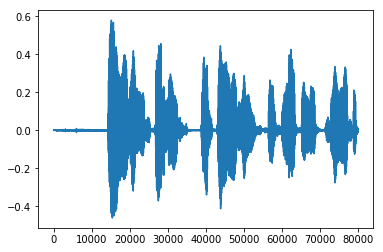

In [14]:
%matplotlib inline

plt.plot(data[0:fs*5])

from IPython.display import Audio
Audio(rate=fs, data=data[0:fs*10])

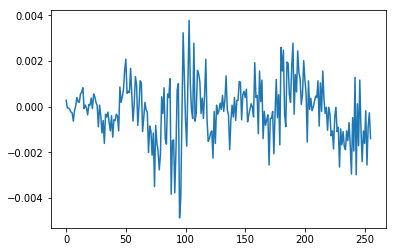

In [15]:
# Example of a speech frame
plt.plot(training_data[10])
data2=training_data[10].reshape(-1,1)
#Audio(data2,rate=fs)
Audio(data=training_data[10],rate=fs)

In [16]:
# Build the dictionary
from sklearn.decomposition import MiniBatchDictionaryLearning
from time import time
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=1024, alpha=1, n_iter=200)
D = dico.fit(training_data).components_
t1 = time() - t0
print('Trained in %d seconds' % t1)

Trained in 59 seconds


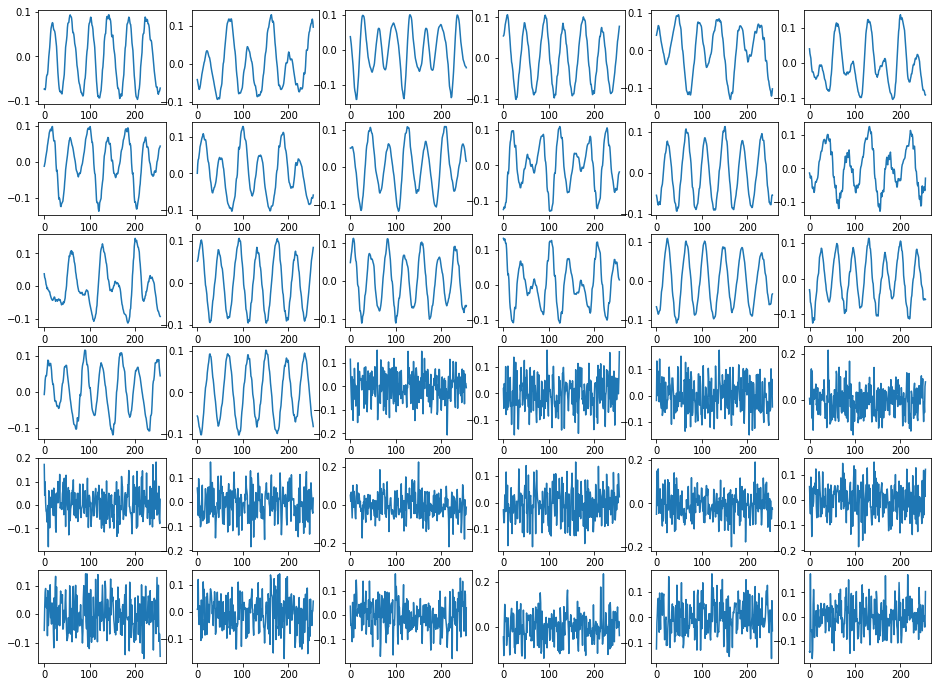

In [17]:
import itertools
# Example of an entry from the dictionary
fig, axes = plt.subplots(6,6)
fig.set_size_inches(16,12)
for i, j in itertools.product(range(1,7), range(6)):
    axes[i-1][j].plot(D[6*(i-1)+j])

Reconstructing speech segments using sparse coding with the learned dictionary
------------------------------------------------------------------------------

Now that we have a dictionary which (supposedly) is good for representing speech signals, let's use Orthogonal Matching Pursuit (OMP) to reconstruct a speech segment based on a linear combination of dictionary entries.

In [23]:
# Get sample speech segment to reconstruct
test_data = data[fs*55:fs*65].reshape(fs*10//256, 256)

# Reconstruct it frame-by-frame using a linear combination of 100 atoms per frame (sparsity-constrained OMP)
result = np.ndarray((test_data.shape[0],512))

from sklearn.decomposition import SparseCoder

coder = SparseCoder(dictionary = D, transform_n_nonzero_coefs=50, transform_alpha=None, transform_algorithm="omp")

t0 = time()
result = coder.transform(test_data)
t1 = time() - t0
print('Coded signal using OMP and learned dictionary in %d seconds.' % t1)

Coded signal using OMP and learned dictionary in 14 seconds.


In [24]:
orig = data[fs*55:fs*65]
#orig = data[0:fs*10]
out = np.zeros(orig.shape)

for n in range(result.shape[0]):
    out[n*256:(n+1)*256] = np.sum(D.T*result[n],axis=1)


In [25]:
Audio(data=data[55*fs:65*fs],rate=fs)

In [26]:
Audio(data=out,rate=fs)

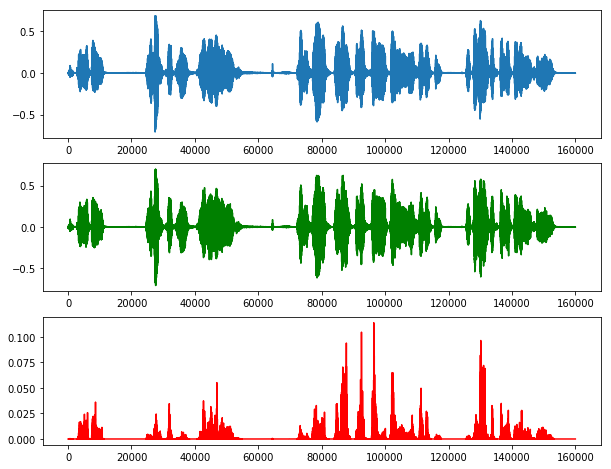

In [27]:
fig, axes = plt.subplots(3)
fig.set_size_inches(10,8)

axes[0].plot(orig)
axes[1].plot(out, 'g')
axes[2].plot((out-orig)**2, 'r')

In [31]:
wavfile.write('reconst.wav', 16000, np.asarray(out, dtype=np.float32))
wavfile.write('orig.wav', 16000, np.asarray(orig, dtype=np.float32))